# End-to-End IMDB Sentiment Analysis

### Loading Libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

### Importing the training dataset

In [14]:
imdb_data=pd.read_csv('IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### Exploratery data analysis

In [15]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### Sentiment Count

In [20]:
sentiment_counts = imdb_data['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### Average review length for positive vs. negative

In [21]:
# Calculate review lengths
imdb_data['review_length'] = imdb_data['review'].apply(lambda x: len(x.split()))

# Compute average length per sentiment
avg_length = imdb_data.groupby('sentiment')['review_length'].mean()
print(avg_length)

sentiment
negative    229.46456
positive    232.84932
Name: review_length, dtype: float64


### Bar Graphs

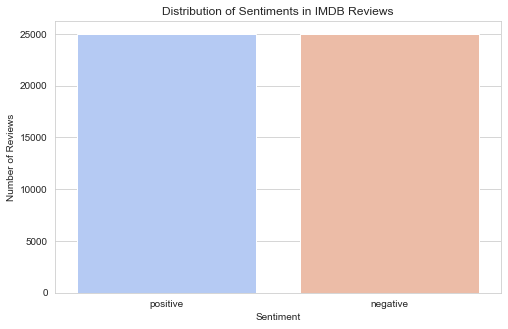

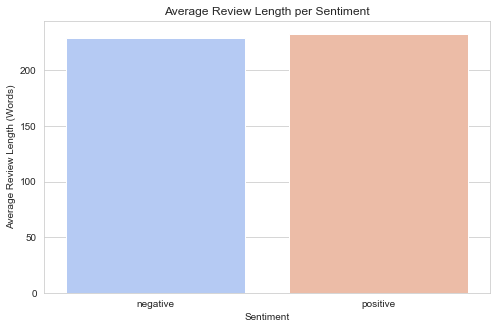

In [22]:
sns.set_style("whitegrid")

# Plotting sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Sentiments in IMDB Reviews")
plt.show()

# Plotting average review length per sentiment
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_length.index, y=avg_length.values, palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Average Review Length (Words)")
plt.title("Average Review Length per Sentiment")
plt.show()

### Splitting the training dataset

In [7]:
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]

#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


### Text Normalization

In [8]:
#Tokenization of text
tokenizer=ToktokTokenizer()

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

### Removing html strips and noise text

In [9]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [10]:
imdb_data['review']=imdb_data['review'].apply(denoise_text)

### Removing special characters

In [11]:
#function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

In [12]:
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

### Text stemming

In [13]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

### Removing stopwords

In [13]:
stop=set(stopwords.words('english'))
print(stop)

{'yourself', "haven't", 'does', 'mustn', "weren't", 'any', 'how', 'by', 'same', "you'll", 'to', 'hadn', 'ain', 'then', 'now', 'd', 'these', 'has', 'this', 'yourselves', 'again', 'won', 'were', "that'll", 'because', 'under', 'weren', 'ourselves', 'being', 'while', 's', 'or', 'haven', 'than', 'from', 'those', 'about', 'down', 'why', 'more', 'mightn', 'don', 'isn', 'off', "aren't", 'them', 'who', 'some', 'during', "mightn't", 'their', 'which', 'once', "shouldn't", 'after', 'just', 'before', 'no', 'very', 'can', 'll', 'all', 'for', 'against', 'is', 'until', 'few', 'own', "couldn't", 'your', 'but', 'will', 't', 'whom', 'are', 'at', 'doesn', 'he', 'further', 'out', 'only', 'ours', 'both', 'been', 'of', 'didn', 'and', 'they', 'her', 'below', 'over', 'not', "mustn't", 'here', 'my', 'having', 'was', 'did', "isn't", 're', 'she', 'itself', 'that', 'on', 'him', "doesn't", 'there', 'i', 'where', 'themselves', "you've", "wasn't", 'a', 'if', 'couldn', "hasn't", 'hers', 'our', 'myself', 'doing', 'am',

In [14]:
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [15]:
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

### Normalized train reviews

In [16]:
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]

'One reviewers mentioned watching 1 Oz episode youll hooked right exactly happened meThe first thing struck Oz brutality unflinching scenes violence set right word GO Trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordIt called OZ nickname given Oswald Maximum Security State Penitentary focuses mainly Emerald City experimental section prison cells glass fronts face inwards privacy high agenda Em City home manyAryans Muslims gangstas Latinos Christians Italians Irish moreso scuffles death stares dodgy dealings shady agreements never far awayI would say main appeal show due fact goes shows wouldnt dare Forget pretty pictures painted mainstream audiences forget charm forget romanceOZ doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste Oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle 

### Normalized test reviews



In [17]:
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]

'read reviews watching piece cinematic garbage took least 2 pages find somebody else didnt think appallingly unfunny montage WASNT acme humour 70s indeed era isnt least funny set sketch comedy Ive ever seen itll till comes along Half skits already done infinitely better acts Monty Python Woody Allen say nice piece animation lasts 90 seconds highlight film would still get close summing mindless drivelridden waste 75 minutes Seminal comedy world seminal really mean semen Scatological humour world scat actually feces Precursor jokes mean handbook comedy Tits bums odd beaver Niceif pubescent boy least one hand free havent found Playboy exists Give break early 70s way sketch comedy going back least ten years prior way could even forgive film even made gunpoint Retro Hardly Sketches clowns subtly perverting children may cutting edge circles could actually funny comes really quite sad kept going throughout entire 75 minutes Sheer belief may saved genuinely funny skit end gave film 1 lower sco

### Bags of words model

#### It is used to convert text documents to numerical vectors or bag of words.

In [18]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))

#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)

#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 7354487)
BOW_cv_test: (10000, 7354487)


### Term Frequency-Inverse Document Frequency model (TFIDF)

#### It is used to convert text documents to matrix of tfidf features.

In [19]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))

#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)

#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 7354487)
Tfidf_test: (10000, 7354487)


### Labeling the sentiment text

In [20]:
lb=LabelBinarizer()
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


### Split the sentiment test data

In [21]:
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


### Modelling the dataset

### Building Logistic Regression model for both bag of words and tfidf features

In [22]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)

#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

C:\Users\deepa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


C:\Users\deepa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


### Logistic regression model performane on test dataset



In [23]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)

#Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]


### Accuracy of the model

In [24]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.8599
lr_tfidf_score : 0.8867


### Printing the classification report

In [25]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.85      0.87      0.86      4993
    Negative       0.87      0.85      0.86      5007

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

              precision    recall  f1-score   support

    Positive       0.89      0.88      0.89      4993
    Negative       0.88      0.89      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Confusion matrix

In [26]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4247  760]
 [ 641 4352]]
[[4477  530]
 [ 603 4390]]


### Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features

In [27]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)

#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)

#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

C:\Users\deepa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


C:\Users\deepa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


### Model performance on test data

In [28]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)

#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]


### Accuracy of the model

In [29]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)

#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.8559
svm_tfidf_score : 0.8839


### Print the classification report

In [30]:
#Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)

#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.83      0.89      0.86      4993
    Negative       0.88      0.82      0.85      5007

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

              precision    recall  f1-score   support

    Positive       0.89      0.87      0.88      4993
    Negative       0.88      0.90      0.89      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Plotting the confusion matrix

In [31]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4125  882]
 [ 559 4434]]
[[4482  525]
 [ 636 4357]]


### Multinomial Naive Bayes for bag of words and tfidf features

In [32]:
#training the model
mnb=MultinomialNB()

#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)

#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

C:\Users\deepa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


C:\Users\deepa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


### Model performance on test data

In [33]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


### Accuracy of the model

In [34]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.8797
mnb_tfidf_score : 0.8895


### Print the classification report

In [35]:
#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)

#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.86      0.91      0.88      4993
    Negative       0.90      0.85      0.88      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

              precision    recall  f1-score   support

    Positive       0.88      0.90      0.89      4993
    Negative       0.89      0.88      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Plot the confusion matrix

In [36]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4268  739]
 [ 464 4529]]
[[4423  584]
 [ 521 4472]]


### Word cloud for positive review words

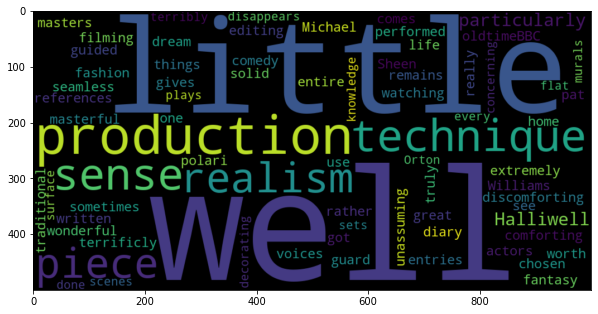

In [37]:
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show()

### Word cloud for negative review words

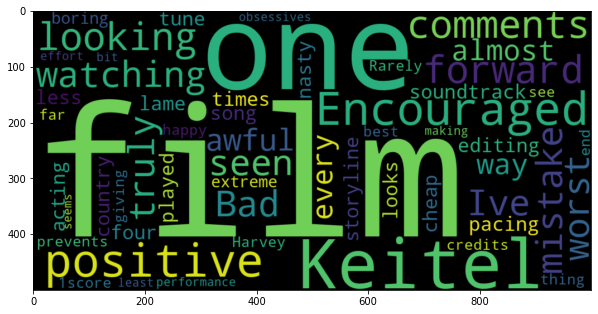

In [38]:
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show()

### Conclusion
#### The analysis of the IMDB movie reviews dataset reveals key insights into sentiment distribution, review length, and model performance:

1) Sentiment Distribution: The dataset has a fairly balanced number of positive and negative reviews, ensuring that our sentiment analysis model does not lean toward one class.

2) Review Length Analysis: On average, positive reviews tend to be longer than negative ones, indicating that users who enjoyed a movie often provide more detailed feedback.

3) Model Performance: We observed that both Logistic Regression and Multinomial Naïve Bayes models perform well compared to Linear Support Vector Machines (SVM). However, there is still room for improvement.

4) Potential Enhancements: The accuracy of the models can be further improved by enhancing data preprocessing techniques and incorporating lexicon-based models like TextBlob, which leverage sentiment dictionaries for better classification.

#### Moving forward, refining feature engineering, experimenting with ensemble models, and integrating deep learning approaches could further boost sentiment classification accuracy.

### Dumping Logistic Regression Model and TF-IDF Vectorizer

In [39]:
import joblib

joblib.dump(lr_tfidf, 'lr_tfidf_model.pkl')
joblib.dump(tv, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']